In [3]:
# !pip install fredapi ruptures

In [ ]:
from dotenv import load_dotenv; load_dotenv()
from typing import Optional, Dict, Tuple
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from fredapi import Fred
from sklearn.decomposition import PCA
import ruptures as rpt

DATA_PATH = os.path.join(os.getenv('DATA_PATH'), 'Gingado')
OUTPUT_PATH = os.path.join(os.getenv('OUTPUT_PATH'), 'datasets')
FRED_API = os.getenv("FRED_API_KEY")

In [5]:
# pd.options.plotting.backend = "plotly"
pd.options.plotting.backend = "matplotlib"

RANDOM_STATE = 42
START_DATE = '1996-01-01'
END_DATE = '2026-01-01'

# Macroeconomic data

**Including:** FED Fund Rates, CPI, PPI, GDP, Unemployment, Nonfarm payrolls

In [6]:
fred = Fred(api_key=FRED_API)

def load_data(start: str, end: str):
    
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime('today') if end is None else pd.to_datetime(end)
    if start_date > end_date:
        raise ValueError("Start date must be before end date.")
    
    start_refined = start_date.strftime('%m/%d/%Y')
    end_refined = end_date.strftime('%m/%d/%Y')

    fedrates = fred.get_series('FEDFUNDS', start_refined, end_refined)  # Federal Funds Rate from FRED
    fedrates.name = 'FED Funds Rate'

    cpi = fred.get_series('CPIAUCNS', start_refined, end_refined)  # CPI from FRED
    cpi.name = 'CPI'

    ppi = fred.get_series('PPIACO', start_refined, end_refined)  # PPI from FRED
    ppi.name = 'PPI'

    gdp = fred.get_series('GDP', start_refined, end_refined)  # GDP from FRED
    gdp.name = 'GDP'

    unemployment = fred.get_series('UNRATE', start_refined, end_refined)  # Unemployment from FRED
    unemployment.name = 'Unemployment'

    nfp = fred.get_series('PAYEMS', start_refined, end_refined)  # Nonfarm Payrolls from FRED
    nfp.name = 'Nonfarm Payrolls'

    # df = pd.concat([fedrates, cpi, ppi, gdp, unemployment, nfp], axis=1)
    df = pd.merge(fedrates, cpi, left_index=True, right_index=True, how='outer')
    df = pd.merge(df, ppi, left_index=True, right_index=True, how='outer')
    df = pd.merge(df, gdp, left_index=True, right_index=True, how='outer')
    df = pd.merge(df, unemployment, left_index=True, right_index=True, how='outer')
    df = pd.merge(df, nfp, left_index=True, right_index=True, how='outer')
    df = df.ffill()

    return df

In [ ]:
macrodata = load_data(START_DATE, END_DATE)
macrodata['date'] = pd.to_datetime(macrodata.index)
macrodata = macrodata.set_index('date')
# macrodata.to_csv(os.path.join(OUTPUT_PATH, f'macroeconomic_data_{START_DATE}-{END_DATE}.csv'))

<Axes: title={'center': 'Scaled Macroeconomic Data (rolling window)'}, xlabel='date'>

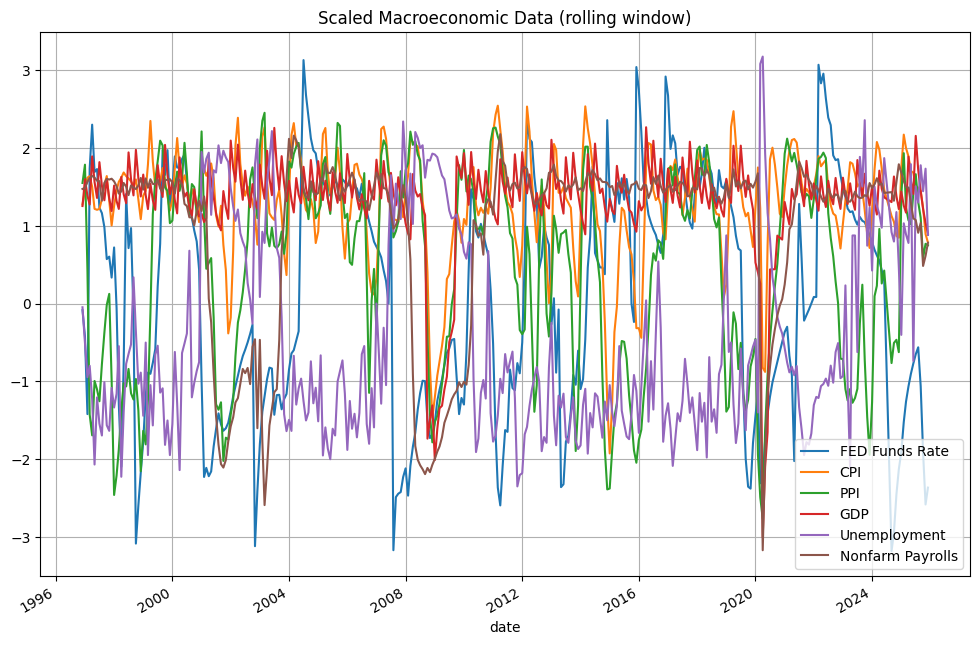

In [8]:
wdw = 12
scaled_data_df = ( macrodata - macrodata.rolling(window=wdw).mean() ) / macrodata.rolling(window=wdw).std()
scaled_data_df.dropna(inplace=True)
scaled_data_df.plot(figsize=(12, 8), subplots=False, title='Scaled Macroeconomic Data (rolling window)', grid=True)

# Macroeconomic indices

In [9]:
scaled_data = scaled_data_df.values
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
pca_cols = [f'PC{i+1}' for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_data, columns=pca_cols)
pca_df.index = scaled_data_df.index

In [10]:
threshold = 0.8
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
n_components_thresh = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components explaining {round(threshold*100)}% of the variance: {n_components_thresh} (out of {scaled_data_df.shape[1]} variables)")

Number of components explaining 80% of the variance: 3 (out of 6 variables)


In [11]:
pca_loadings = pd.DataFrame(pca.components_, index=pca_cols, columns=macrodata.columns).mul(100)
pca_loadings["Explained Variance"] = pca.explained_variance_ratio_ * 100
styled_df = (
    pca_loadings
    .style
    .format("{:.2f}%")
    .background_gradient(cmap='coolwarm', vmin=-100, vmax=100, axis=None, subset=pca_loadings.columns[:-1])  # Exclude last col
    .background_gradient(cmap='Greys', vmin=0, vmax=100, subset=['Explained Variance'])  # Custom for Explained Variance
    .set_properties(**{
        'font-size': '15px',
        'padding': '12px',
        'text-align': 'center'
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '18px'), ('padding', '12px')]},
        {'selector': 'td.col_heading.level0', 'props': [('border-right', 'px solid black')]},  # Optional right border
        {'selector': 'td.col_heading.level1', 'props': [('border-right', '2px solid black')]}
    ])
)
styled_df

,FED Funds Rate,CPI,PPI,GDP,Unemployment,Nonfarm Payrolls,Explained Variance
PC1,62.24%,10.80%,18.97%,16.87%,-56.29%,46.86%,48.76%
PC2,-30.03%,35.01%,87.27%,14.20%,7.43%,0.29%,23.09%
PC3,71.22%,-5.30%,25.27%,-12.96%,42.69%,-47.65%,15.12%
PC4,11.42%,30.93%,-20.98%,41.56%,65.36%,49.74%,6.37%
PC5,1.79%,46.96%,-25.36%,58.58%,-25.93%,-55.17%,4.01%
PC6,4.32%,73.94%,-17.40%,-64.70%,-3.10%,3.83%,2.65%


### Index Construction
- **PC1**: Core macro–policy strength signal (main index)
- **PC2**: Orthogonal inflation dimension
- **PC3**: Labor–policy divergence (optional)
- **PC5**: Growth-Payroll Divergence (optional)

We focus on PC1 and PC2.

<Axes: title={'center': 'First Two Principal Components Over Time'}, xlabel='date'>

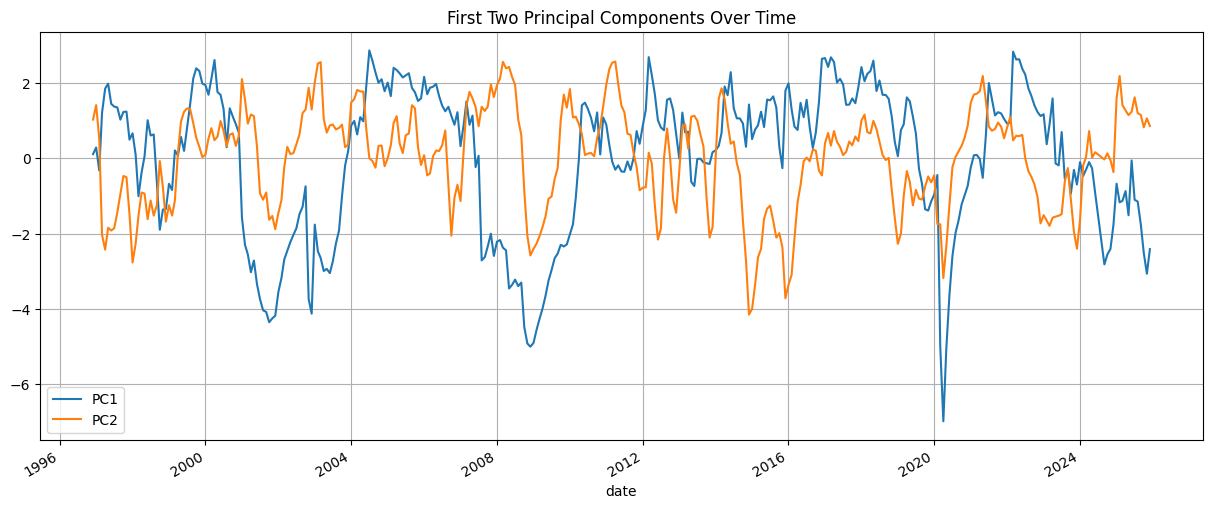

In [12]:
pca_df[['PC1', 'PC2']].plot(figsize=(15, 6), title='First Two Principal Components Over Time', grid=True)

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_61677/3292947620.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


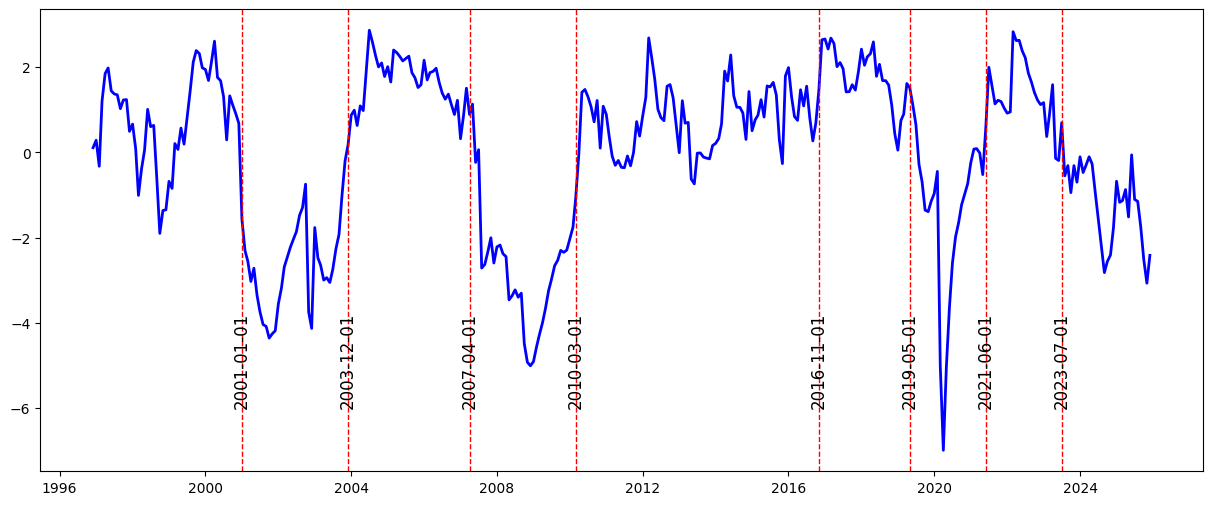

In [13]:
macro_index = pca_df['PC1']
algo = rpt.Pelt(model="rbf").fit(macro_index.values)
breaks_macro = algo.predict(pen=4)[:-1] # Penalty controls number of breaks; tune as needed
break_dates_macro = [macro_index.index[i-1] for i in breaks_macro]

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(macro_index.index, macro_index.values, label="Macro Strength Index", color='blue', linewidth=2)
for i in range(len(break_dates_macro)):
    ax.axvline(x=break_dates_macro[i], color='red', linestyle='--', linewidth=1)
    ax.text(break_dates_macro[i], -6, break_dates_macro[i].strftime('%Y-%m-%d'), rotation=90, ha='center', va='bottom', fontsize=12)
fig.show()

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_61677/2656215271.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


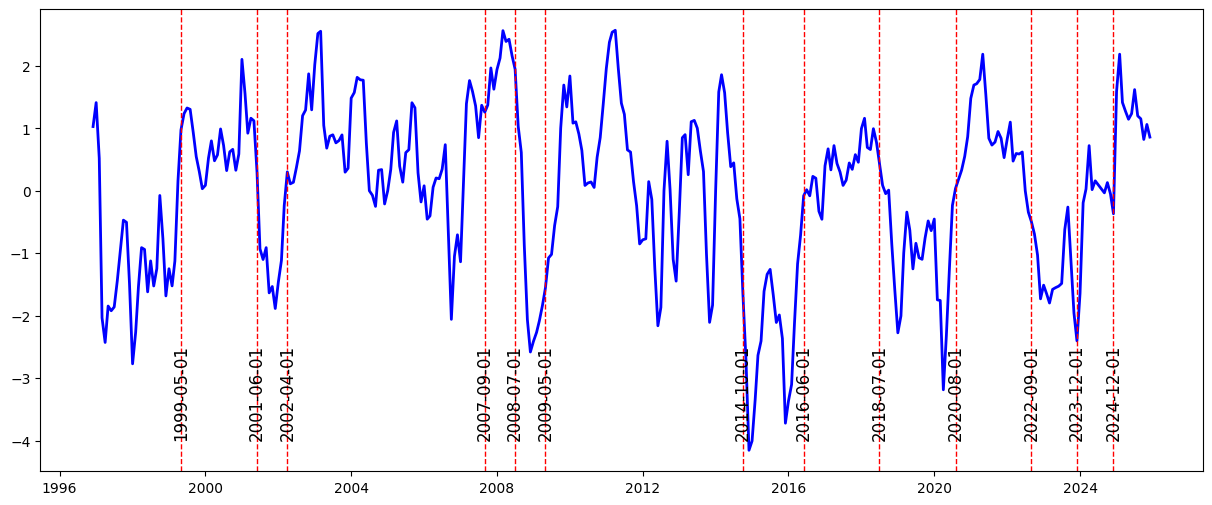

In [14]:
inflation_index = pca_df['PC2']
algo = rpt.Pelt(model="rbf").fit(inflation_index.values)
breaks_inflation = algo.predict(pen=4)[:-1] # Penalty controls number of breaks; tune as needed
break_dates_inflation = [inflation_index.index[i-1] for i in breaks_inflation]

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(inflation_index.index, inflation_index.values, label="Inflation Index", color='blue', linewidth=2)
for i in range(len(break_dates_inflation)):
    ax.axvline(x=break_dates_inflation[i], color='red', linestyle='--', linewidth=1)
    ax.text(break_dates_inflation[i], -4, break_dates_inflation[i].strftime('%Y-%m-%d'), rotation=90, ha='center', va='bottom', fontsize=12)
fig.show()

# US Central Bank Speeches

In [15]:
us_speeches = pd.read_parquet(os.path.join(OUTPUT_PATH, 'gingado-cb-speeches_19960910-20251225_NER.parquet'))
us_speeches.set_index('date', inplace=True)
us_speeches = us_speeches[us_speeches['country_code'] == 'US']
us_speeches["hawkish"] = 0
us_speeches.loc[us_speeches['sentiment'] == 'hawkish', 'hawkish'] = 1
us_speeches["dovish"] = 0
us_speeches.loc[us_speeches['sentiment'] == 'dovish', 'dovish'] = 1

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_61677/2656994627.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(us_speeches_monthly.index.strftime('%Y-%m'))#, rotation=90)


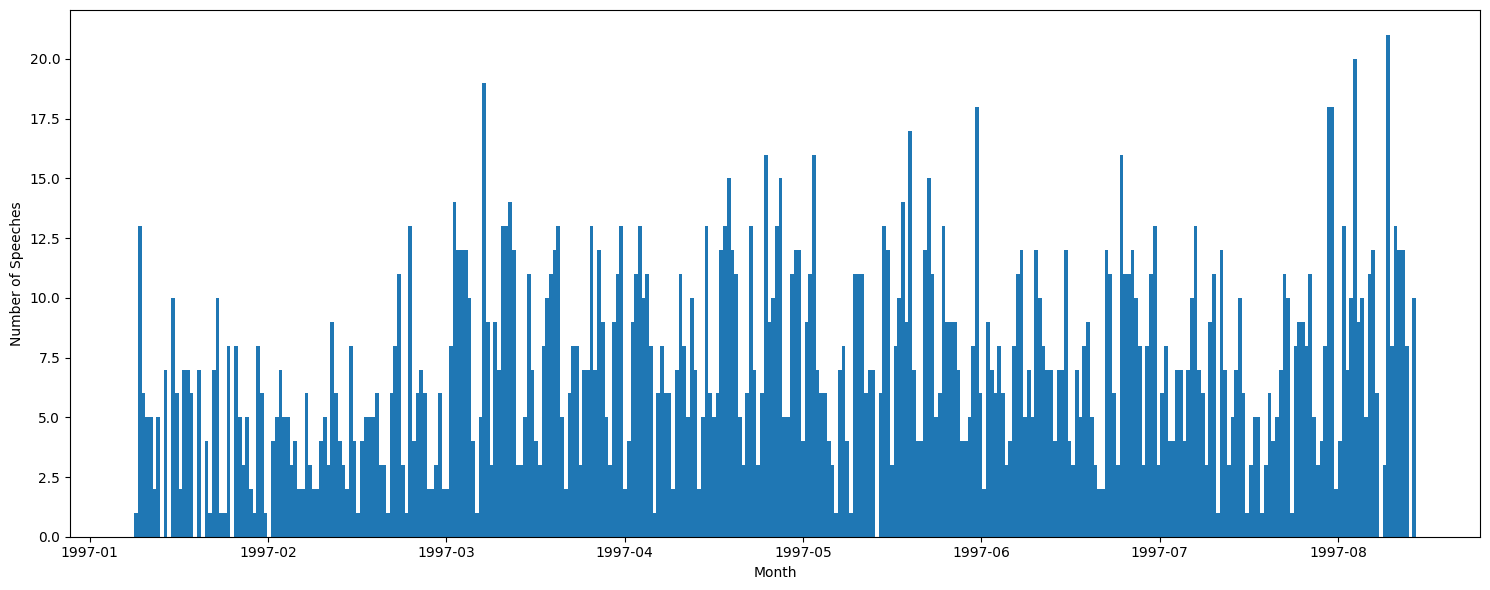

In [16]:
us_speeches_monthly = us_speeches.resample('ME').size()

fig, ax = plt.subplots(figsize=(15, 6))
ax.hist(us_speeches_monthly.index, weights=us_speeches_monthly.values, bins=len(us_speeches_monthly.index))
ax.set_xlabel('Month')
ax.set_ylabel('Number of Speeches')
# ax.set_xticks(us_speeches_monthly.index.year.unique())
ax.set_xticklabels(us_speeches_monthly.index.strftime('%Y-%m'))#, rotation=90)
plt.tight_layout()
plt.show()

del us_speeches_monthly

In [17]:
cb_sentiment = us_speeches[["hawkish", "dovish"]].copy()
cb_sentiment.index = cb_sentiment.index.date
cb_sentiment = cb_sentiment.groupby(cb_sentiment.index).sum()
cb_sentiment = cb_sentiment.reindex(pd.date_range(START_DATE, END_DATE, freq='D')).fillna(0.0)#.shift()
# cb_sentiment = cb_sentiment.rolling(365).sum()
cb_sentiment = cb_sentiment.resample('MS').sum().shift() # Resample to month-start and shift to avoid lookahead bias
cb_sentiment = ( cb_sentiment - cb_sentiment.rolling(window=12).mean() ) / cb_sentiment.rolling(window=12).std()

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_61677/3685453460.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


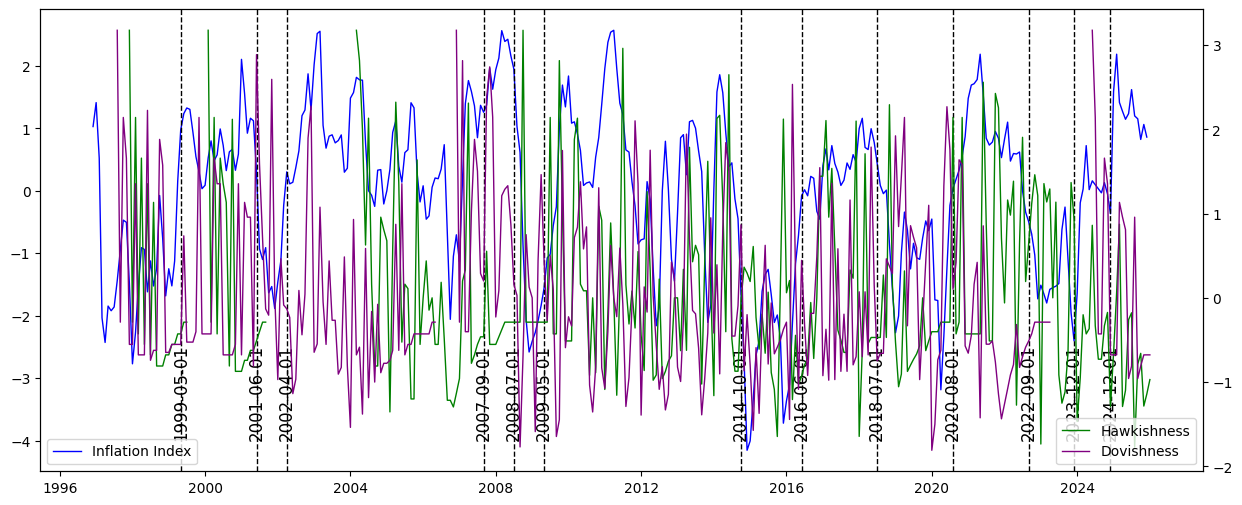

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))

# ax.plot(macro_index.index, macro_index.values, label="Macro Strength Index", color='blue', linewidth=1)
# for i in range(len(break_dates_macro)):
#     ax.axvline(x=break_dates_macro[i], color='black', linestyle='--', linewidth=1)
#     ax.text(break_dates_macro[i], -6, break_dates_macro[i].strftime('%Y-%m-%d'), rotation=90, ha='center', va='bottom', fontsize=12)
ax.plot(inflation_index.index, inflation_index.values, label="Inflation Index", color='blue', linewidth=1)
for i in range(len(break_dates_inflation)):
    ax.axvline(x=break_dates_inflation[i], color='black', linestyle='--', linewidth=1)
    ax.text(break_dates_inflation[i], -4, break_dates_inflation[i].strftime('%Y-%m-%d'), rotation=90, ha='center', va='bottom', fontsize=12)
ax.legend(loc='lower left')

ax2 = ax.twinx()
ax2.plot(cb_sentiment.index, cb_sentiment['hawkish'], label="Hawkishness", color='green', linewidth=1)
ax2.plot(cb_sentiment.index, cb_sentiment['dovish'], label="Dovishness", color='purple', linewidth=1)
ax2.legend(loc='lower right')

fig.show()

# Speeches and Macroeconomic envrionment alignement

In [19]:
def beta_1pred(
    factors: pd.DataFrame,
    assets: pd.DataFrame,
    window: int = 252,
    min_periods: Optional[int] = None,
    expanding: bool = False,
    adj_rsquared: bool = False,
    dtype: str = "float32",
) -> Tuple[Dict[str, pd.DataFrame], Dict[str, pd.DataFrame]]:
    if min_periods is None:
        min_periods = window

    factors = factors.astype(dtype)
    assets  = assets.astype(dtype)

    betas_dict: Dict[str, pd.DataFrame] = {}
    r2_dict: Dict[str, pd.DataFrame] = {}

    for fac in factors.columns:
        x = factors[fac]

        if expanding:
            cov_ax = assets.expanding(min_periods=min_periods).cov(x)
            var_x  = x.expanding(min_periods=min_periods).var()
            var_y  = assets.expanding(min_periods=min_periods).var()
        else:
            cov_ax = assets.rolling(window, min_periods=min_periods).cov(x)
            var_x  = x.rolling(window, min_periods=min_periods).var()
            var_y  = assets.rolling(window, min_periods=min_periods).var()

        # β = Cov(x, y) / Var(x)
        beta = cov_ax.div(var_x, axis=0) # centered ⇒ OLS without intercept
        betas_dict[fac] = beta

        # Adjusted R² = 1 - (1 - R²) * (n - 1) / (n - k - 1), with k=1
        if adj_rsquared:
            n_obs = assets.rolling(window, min_periods=min_periods).count()
            r2_dict[fac] = 1 - (1 - (cov_ax ** 2).div(var_y.mul(var_x, axis=0), axis=0)) * (n_obs - 1) / (n_obs - 1 - 1)
        
        # R² = Cov(x, y)² / (Var(x) * Var(y))
        else:
            r2_dict[fac] = (cov_ax ** 2).div(var_y.mul(var_x, axis=0), axis=0)

    return betas_dict, r2_dict

### Macro Economic Index vs. Hawkish/dovishness

In [20]:
df = pd.merge(macro_index.rename("Macro Index"), cb_sentiment, left_index=True, right_index=True, how='outer').ffill().dropna()
df = df.diff().dropna()
betas_dict, r2_dict = beta_1pred(factors=df[["hawkish", "dovish"]], assets=df[["Macro Index"]], window=3*12, expanding=False, adj_rsquared=False, dtype="float32")

In [21]:
for col in df.columns:
    print(col, '---', df[col].autocorr(lag=1))
    # pd.plotting.autocorrelation_plot(df[col])
df.corr()

Macro Index --- 0.022736291270496162
hawkish --- -0.42893153750661067
dovish --- -0.379112367305506


,Macro Index,hawkish,dovish
Macro Index,1.000000,0.007605,-0.001215
hawkish,0.007605,1.000000,0.084932
dovish,-0.001215,0.084932,1.000000


/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_61677/2931630052.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


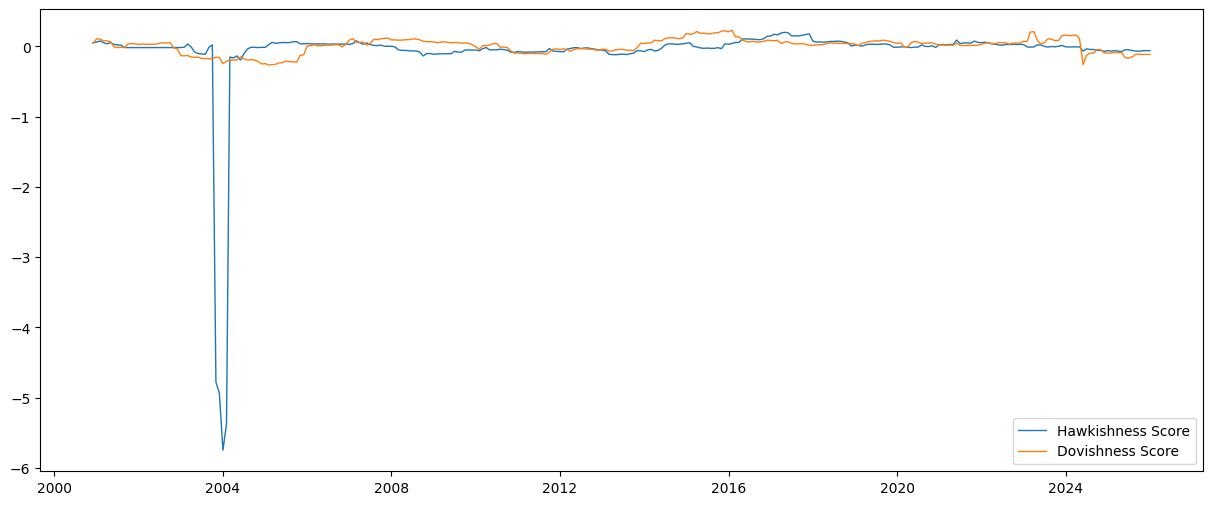

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(betas_dict["hawkish"].index, betas_dict["hawkish"].values, label="Hawkishness Score", linewidth=1)
ax.plot(betas_dict["dovish"].index, betas_dict["dovish"].values, label="Dovishness Score", linewidth=1)
ax.legend()
fig.show()

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_61677/2493099950.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


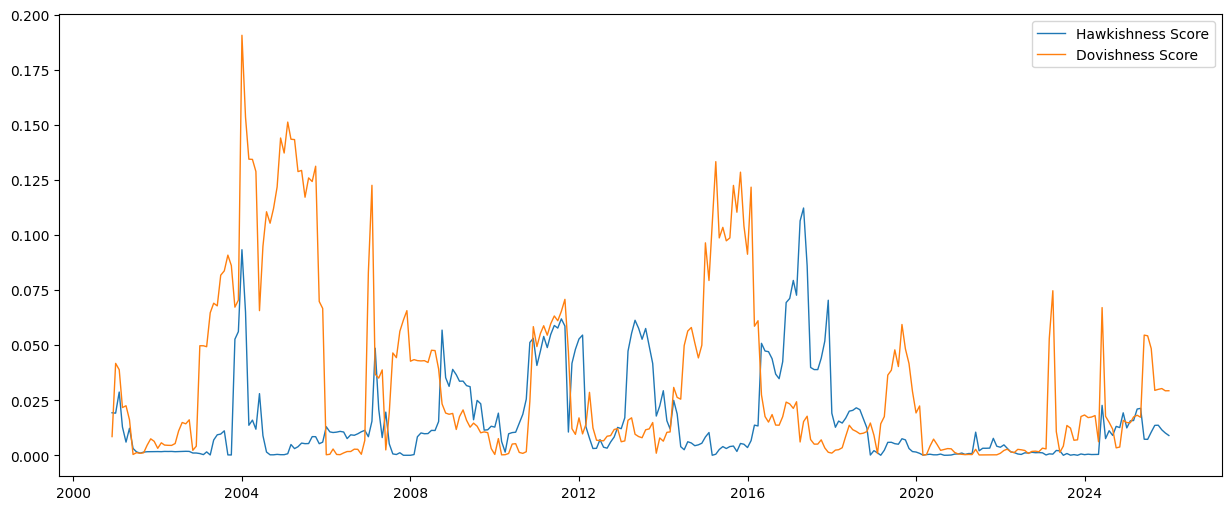

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(r2_dict["hawkish"].index, r2_dict["hawkish"].values, label="Hawkishness Score", linewidth=1)
ax.plot(r2_dict["dovish"].index, r2_dict["dovish"].values, label="Dovishness Score", linewidth=1)
ax.legend()
fig.show()

### Inflation Index vs. Hawkish/dovishness

In [24]:
df = pd.merge(inflation_index.rename("Inflation Index"), cb_sentiment, left_index=True, right_index=True, how='outer').ffill().dropna()
df = df.diff().dropna()
betas_dict, r2_dict = beta_1pred(factors=df[["hawkish", "dovish"]], assets=df[["Inflation Index"]], window=3*12, expanding=False, adj_rsquared=False, dtype="float32")

In [25]:
for col in df.columns:
    print(col, '---', df[col].autocorr(lag=1))
    # pd.plotting.autocorrelation_plot(df[col])
df.corr()

Inflation Index --- 0.28746593898895745
hawkish --- -0.42893153750661067
dovish --- -0.379112367305506


,Inflation Index,hawkish,dovish
Inflation Index,1.000000,0.005434,-0.028549
hawkish,0.005434,1.000000,0.084932
dovish,-0.028549,0.084932,1.000000


/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_61677/2931630052.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


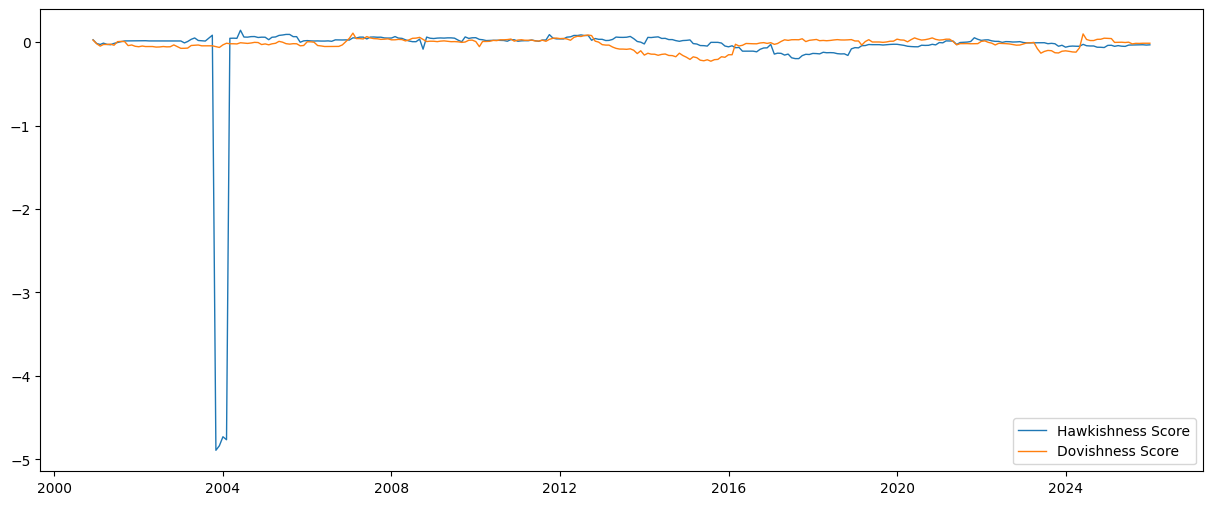

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(betas_dict["hawkish"].index, betas_dict["hawkish"].values, label="Hawkishness Score", linewidth=1)
ax.plot(betas_dict["dovish"].index, betas_dict["dovish"].values, label="Dovishness Score", linewidth=1)
ax.legend()
fig.show()

/var/folders/2k/kyptfbxj6l762gddhr91n4j80000gs/T/ipykernel_61677/2493099950.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


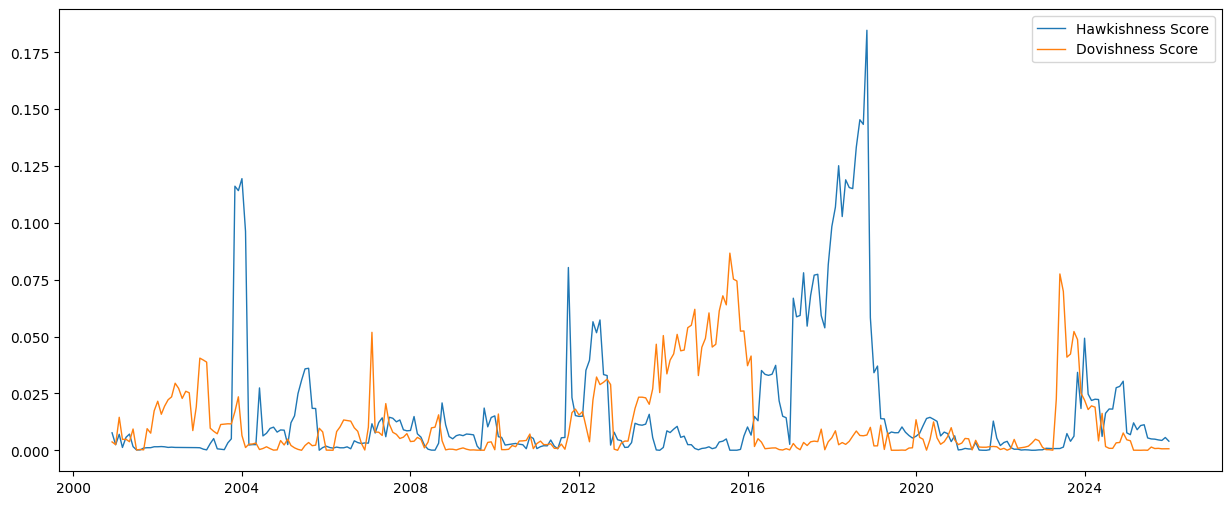

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(r2_dict["hawkish"].index, r2_dict["hawkish"].values, label="Hawkishness Score", linewidth=1)
ax.plot(r2_dict["dovish"].index, r2_dict["dovish"].values, label="Dovishness Score", linewidth=1)
ax.legend()
fig.show()